In [1]:
# This is the simplified python script that demonstrates how to directly run slide-seq v1 dataset with BANKSY
import os, time, random, gc
import anndata
from anndata import AnnData
import numpy as np
import pandas as pd
import warnings
from banksy_utils.color_lists import spagcn_color
warnings.filterwarnings("ignore")
import scanpy as sc
sc.logging.print_header()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 1  # errors (0), warnings (1), info (2), hints (3)

seed = 0
np.random.seed(seed)
random.seed(seed)
start = time.perf_counter_ns()

scanpy==1.9.5 anndata==0.10.2 umap==0.5.4 numpy==1.24.4 scipy==1.11.3 pandas==2.1.1 scikit-learn==1.3.1 statsmodels==0.14.0 igraph==0.10.6 pynndescent==0.5.10


### Analysis for CODEX
- Dataset is publically available here [CODEX dataset](https://datadryad.org/stash/dataset/doi:10.5061/dryad.pk0p2ngrf). 
- Download the file `GSM7423_09_CODEX_HuBMAP_alldata_Dryad_merged.csv` (a healthy colon HC sample).
- Arrange it under `data/CODEX/23_09_CODEX_HuBMAP_alldata_Dryad_merged`

In [2]:
file_path = os.path.join("data", "CODEX","CODEX_csv_data")
metadata_file = "23_09_CODEX_HuBMAP_alldata_Dryad_merged.csv"
meta_df = pd.read_csv(os.path.join(file_path, metadata_file), index_col=0)

`CODEX` dataset: This dataset contains samples from all donors. Here, we focus on identifying tissue segments from the transverse segment for donor B008. This can be accessed via `meta_df['unique_region'] == B008_Trans`

In [3]:
# See all unique regions availale for clustering
meta_df['unique_region'].unique()

array(['B004_Ascending', 'B005_Ascending', 'B006_Ascending', 'B009_Right',
       'B010_Right', 'B011_Right', 'B012_Right', 'B008_Right',
       'B004_Descending', 'B005_Descending', 'B006_Descending',
       'B009_Left', 'B012_Left', 'B011_Left', 'B010_Left', 'B008_Left',
       'B005_Duodenum', 'B004_Duodenum', 'B006_Duodenum', 'B009_Duodenum',
       'B011_Duodenum', 'B012_Duodenum', 'B010_Duodenum', 'B008_Duodenum',
       'B004_Ileum', 'B005_Ileum', 'B006_Ileum', 'B009_Ileum',
       'B010_Ileum', 'B011_Ileum', 'B012_Ileum', 'B008_Ileum',
       'B006_Mid-jejunum', 'B004_Mid-jejunum', 'B005_Mid-jejunum',
       'B009_Mid jejunum', 'B009_Mid jejunum_extra', 'B011_Mid jejunum',
       'B012_Mid jejunum', 'B010_Mid jejunum', 'B008_Mid jejunum',
       'B004_Proximal Jejunum', 'B005_Proximal Jejunum',
       'B006_Proximal Jejunum', 'B011_Proximal jejunum',
       'B009_Proximal jejunum', 'B010_Proximal jejunum',
       'B012_Proximal jejunum', 'B008_Proximal jejunum',
       'B008_Pr

In [4]:
unique_regions = ["B012_Ileum", "B012_Right", "B012_Trans"]
meta_df = meta_df.loc[meta_df['unique_region'].isin(unique_regions)]
meta_df

MUC2      SOX9      MUC1      CD31   Synapto     CD49f      CD15  \
77014   -0.221731 -0.212664 -0.184115 -0.252717 -0.274699 -0.379466 -0.215366   
77015   -0.221731 -0.223280  0.455716 -0.255798 -0.247580  0.314626 -0.055518   
77016   -0.221731 -0.223280  0.135214 -0.255017 -0.274699  1.966520  0.123471   
77017   -0.221731 -0.176880  0.117489 -0.254624 -0.273389  0.123932 -0.215366   
77018   -0.221731 -0.163267 -0.354433 -0.256254 -0.274699 -0.288124 -0.215366   
...           ...       ...       ...       ...       ...       ...       ...   
2580933 -0.194817 -0.188965 -0.292849 -0.241894 -0.274699 -0.373100 -0.194276   
2580934 -0.221731 -0.219685 -0.317896 -0.250129 -0.274699 -0.366723 -0.192548   
2580935 -0.185293 -0.142872 -0.376119 -0.203402 -0.247169 -0.377748 -0.207476   
2580936 -0.063625 -0.218044 -0.249470 -0.191598 -0.237444 -0.360687 -0.015673   
2580937 -0.209438 -0.207672 -0.357490 -0.244580 -0.152761 -0.373199 -0.197869   

             CHGA      CDX2     ITLN1  ...  Cell Type em  Cell subtype  \
77014   -0.064974 -0.233916 -0.354025  ...    Cycling TA    Epithelial   
77015   -0.109297 -0.021358 -0.271637  ...    Cycling TA    Epithelial   
77016   -0.111745 -0.243423 -0.337785  ...    Cycling TA    Epithelial   
77017   -0.109677 -0.199404 -0.316332  ...    Cycling TA    Epithelial   
77018    0.081588 -0.133101 -0.276248  ...    Cycling TA    Epithelial   
...           ...       ...       ...  ...           ...           ...   
2580933 -0.110583 -0.231983 -0.246164  ...            DC        Immune   
2580934 -0.110052 -0.237800  0.114372  ...            DC        Immune   
2580935 -0.111565 -0.183017 -0.321927  ...            DC        Immune   
2580936 -0.112196 -0.222865 -0.165054  ...            DC        Immune   
2580937 -0.112401 -0.230622 -0.095579  ...            DC        Immune   

                     Neighborhood   Neigh_sub         Neighborhood_Ind  \
77014     Transit Amplifying Zone  Epithelial  Neuroendocrine Enriched   
77015        Secretory Epithelial  Epithelial      CD8+ T Enriched IEL   
77016     Transit Amplifying Zone  Epithelial     Secretory Epithelial   
77017        Secretory Epithelial  Epithelial     Secretory Epithelial   
77018    Adatpive Immune Enriched      Immune      CD8+ T Enriched IEL   
...                           ...         ...                      ...   
2580933    Innate Immune Enriched      Immune   Innate Immune Enriched   
2580934    Innate Immune Enriched      Immune   Innate Immune Enriched   
2580935          Microvasculature     Stromal         Microvasculature   
2580936    Innate Immune Enriched      Immune   Innate Immune Enriched   
2580937    Innate Immune Enriched      Immune   Innate Immune Enriched   

         NeighInd_sub                 Community  Major Community  \
77014      Epithelial      Secretory Epithelial       Epithelial   
77015          Immune      Secretory Epithelial       Epithelial   
77016      Epithelial      Secretory Epithelial       Epithelial   
77017      Epithelial      Secretory Epithelial       Epithelial   
77018          Immune  Adaptive Immune Enriched           Immune   
...               ...                       ...              ...   
2580933        Immune      Secretory Epithelial       Epithelial   
2580934        Immune      Secretory Epithelial       Epithelial   
2580935       Stromal                    Stroma           Stroma   
2580936        Immune      Secretory Epithelial       Epithelial   
2580937        Immune    Innate Immune Enriched           Immune   

         Tissue Segment  Tissue Unit  
77014            Mucosa       Mucosa  
77015            Mucosa       Mucosa  
77016            Mucosa       Mucosa  
77017            Mucosa       Mucosa  
77018            Mucosa       Mucosa  
...                 ...          ...  
2580933          Mucosa       Mucosa  
2580934          Mucosa       Mucosa  
2580935        Subucosa    Submucosa  
2580936          Mucosa       Mucosa  
2580937         

### Create AnnData object
- The dataset can be split into the `cell-expression matrix` (indexed from columns 1 to 47) and rest of the metadata (indexed from columns 47 onwards) this also including the position of cells under `XCorr` and `YCorr`.
- Here, we will focus on the `Right` region

In [5]:
right_df =  meta_df.loc[meta_df['unique_region'] == 'B012_Right']
adata = AnnData(X = np.array(right_df.iloc[:, :47]), obs = right_df.iloc[:, 47:])
adata.var_names_make_unique()

gc.collect()

25893

### Pre-process the loaded data
1. Add the position array under `adata.obsm['coord_xy']`

In [6]:
# Stack coordinate array
coord_keys = ('Xcorr', 'Ycorr', 'coord_xy')
adata.obsm[coord_keys[2]] = np.vstack((adata.obs[coord_keys[0]].values,adata.obs[coord_keys[1]].values)).T

adata.obs

x       y  array    Xcorr   Ycorr Tissue_location tissue donor  \
77014   7678.0  1819.0  B012A  17086.0  1819.0       Ascending     CL  B012   
77015   5676.0  8650.0  B012A  15084.0  8650.0       Ascending     CL  B012   
77016   7868.0  2485.0  B012A  17276.0  2485.0       Ascending     CL  B012   
77017   7948.0   981.0  B012A  17356.0   981.0       Ascending     CL  B012   
77018   7681.0  1876.0  B012A  17089.0  1876.0       Ascending     CL  B012   
...        ...     ...    ...      ...     ...             ...    ...   ...   
204005  7806.0  7139.0  B012A  17214.0  7139.0       Ascending     CL  B012   
204006  6738.0  7777.0  B012A  16146.0  7777.0       Ascending     CL  B012   
204007  9080.0  3649.0  B012A  18488.0  3649.0       Ascending     CL  B012   
204008  6098.0  6211.0  B012A  15506.0  6211.0       Ascending     CL  B012   
204009  8837.0  5526.0  B012A  18245.0  5526.0       Ascending     CL  B012   

       unique_region  region  ...  Cell Type em  Cell subtype  \
77014     B012_Right     2.0  ...    Cycling TA    Epithelial   
77015     B012_Right     2.0  ...    Cycling TA    Epithelial   
77016     B012_Right     2.0  ...    Cycling TA    Epithelial   
77017     B012_Right     2.0  ...    Cycling TA    Epithelial   
77018     B012_Right     2.0  ...    Cycling TA    Epithelial   
...              ...     ...  ...           ...           ...   
204005    B012_Right     2.0  ...            DC        Immune   
204006    B012_Right     2.0  ...            DC        Immune   
204007    B012_Right     2.0  ...            DC        Immune   
204008    B012_Right     2.0  ...            DC        Immune   
204009    B012_Right     2.0  ...            DC        Immune   

                    Neighborhood   Neigh_sub          Neighborhood_Ind  \
77014    Transit Amplifying Zone  Epithelial   Neuroendocrine Enriched   
77015       Secretory Epithelial  Epithelial       CD8+ T Enriched IEL   
77016    Transit Amplifying Zone  Epithelial      Secretory Epithelial   
77017       Secretory Epithelial  Epithelial      Secretory Epithelial   
77018   Adatpive Immune Enriched      Immune       CD8+ T Enriched IEL   
...                          ...         ...                       ...   
204005    Innate Immune Enriched      Immune  Adatpive Immune Enriched   
204006    Innate Immune Enriched      Immune  Adatpive Immune Enriched   
204007    Innate Immune Enriched      Immune          Microvasculature   
204008          Microvasculature     Stromal          Microvasculature   
204009    Innate Immune Enriched      Immune    Innate Immune Enriched   

        NeighInd_sub                 Community Major Community Tissue Segment  \
77014     Epithelial      Secretory Epithelial      Epithelial         Mucosa   
77015         Immune      Secretory Epithelial      Epithelial         Mucosa   
77016     Epithelial      Secretory Epithelial      Epithelial         Mucosa   
77017     Epithelial      Secretory Epithelial      Epithelial         Mucosa   
77018         Immune  Adaptive Immune Enriched          Immune         Mucosa   
...              ...                       ...             ...            ...   
204005        Immune      Plasma Cell Enriched          Immune         Mucosa   
204006        Immune      Plasma Cell Enriched          Immune         Mucosa   
204007       Stromal    Innate Immune Enriched          Immune         Mucosa   
204008       Stromal                    Stroma          Stroma       Subucosa   
204009        Immune    Innate Immune Enriched          Immune         Mucosa   

       Tissue Unit  
77014       Mucosa  
77015       Mucosa  
77016       Mucosa  
77017       Mucosa  
77018       Mucosa  
...            ...  
204005      Mucosa  
204006      Mucosa  
204007      Mucosa  
204008   Submucosa  
204009      Mucosa  

[25403 rows x 27 columns]

### Preliminary Analysis
- In CODEX, we want to visualize the communities (8 different classes) in the `B006_ascending` tissue segment
- We first visualize the spatial distribution of the 8 different `communities`.

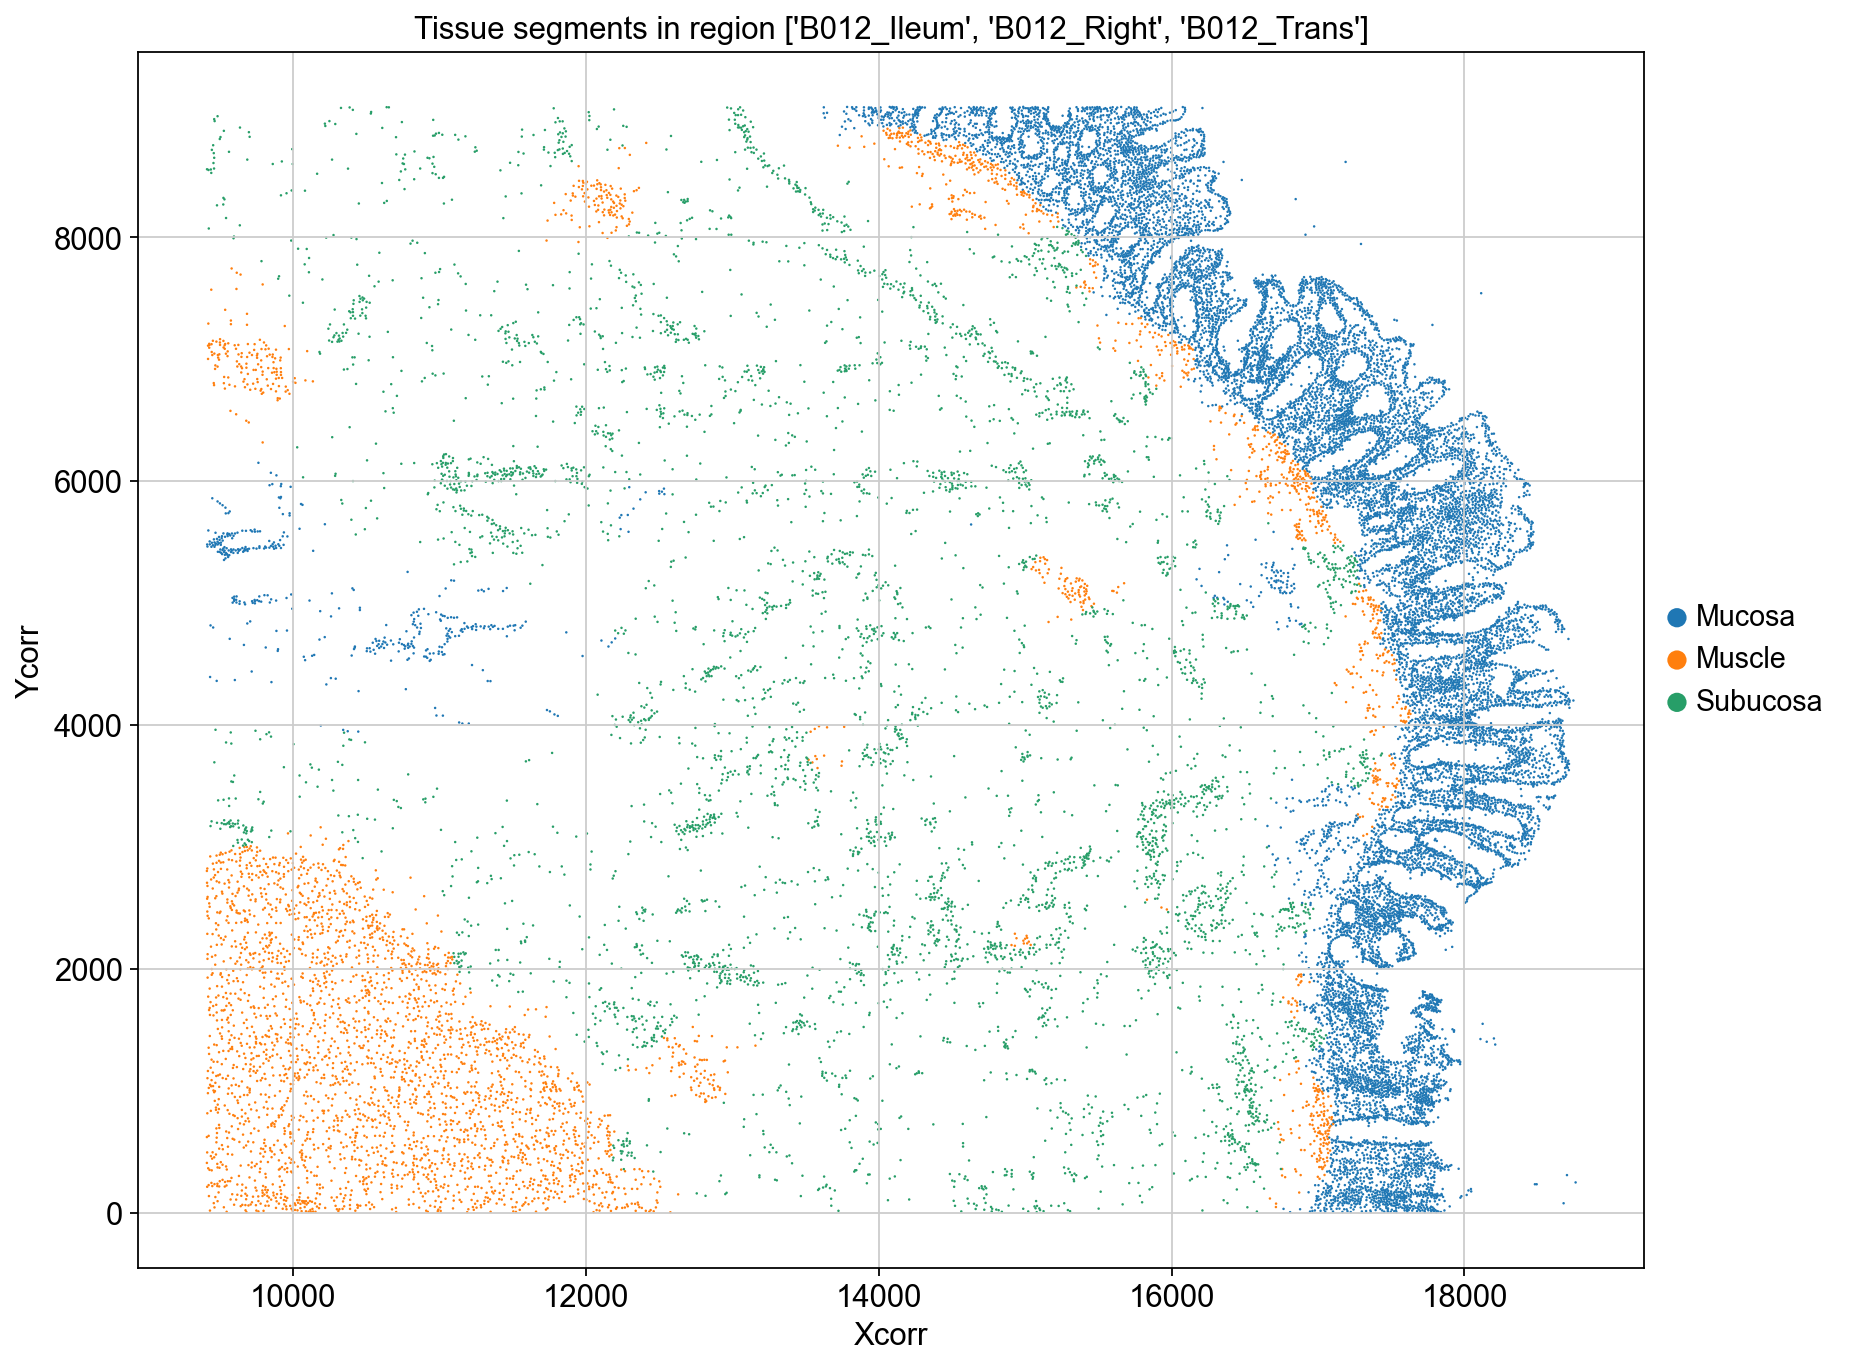

In [7]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
cmap = plt.get_cmap('tab20')
sc.pl.scatter(adata, x='Xcorr', y='Ycorr', color='Tissue Segment',  color_map=cmap, title=f"Tissue segments in region {unique_regions}", show = False,size = 5)
plt.show()

## Running BANKSY
Finally we run BANKSY using the following (default) parameters for `cell-typing`:
- $k_{geom} = 15 $
-  $\lambda = 0.2$
- m = 1 (first order azimuthal transform)
</br>

From, the BANKSY embeddings, we then
- Run PCA with 20 PCs
- Perform Leiden clustering with a resolution parameter of 2.0
<br>

In [8]:
from banksy.main import median_dist_to_nearest_neighbour
from banksy.initialize_banksy import initialize_banksy
from banksy.embed_banksy import generate_banksy_matrix
from banksy.main import concatenate_all

k_geom = 15  # only for fixed type
max_m = 1  # azumithal transform up to kth order
nbr_weight_decay = "scaled_gaussian"  # can also be "reciprocal", "uniform" or "ranked"
resolutions = list(np.arange(0.08, 0.1, 0.005))#[0.08]  # clustering resolution for leiden algorithm
max_labels = None # Number of clusters for tissue segmentation
pca_dims = [20]  # Dimensionality in which PCA reduces to
lambda_list = [0.8]

### Initalize the weighted neighbourhood graphs for BANKSY 


Median distance to closest cell = 16.64331697709324

---- Ran median_dist_to_nearest_neighbour in 0.17 s ----


Median distance to closest cell = 16.64331697709324

---- Ran median_dist_to_nearest_neighbour in 0.19 s ----

---- Ran generate_spatial_distance_graph in 0.43 s ----

---- Ran row_normalize in 0.18 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 1.73 s ----

---- Ran generate_spatial_distance_graph in 0.43 s ----

---- Ran theta_from_spatial_graph in 0.34 s ----

---- Ran row_normalize in 0.12 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 2.02 s ----

----- Plotting Weights Graph -----
Maximum weight: 0.20195381256526168

---- Ran plot_graph_weights in 4.77 s ----

Maximum weight: (0.09115771011716436-0.005064317228731354j)

---- Ran plot_graph_weights in 10.09 s ----



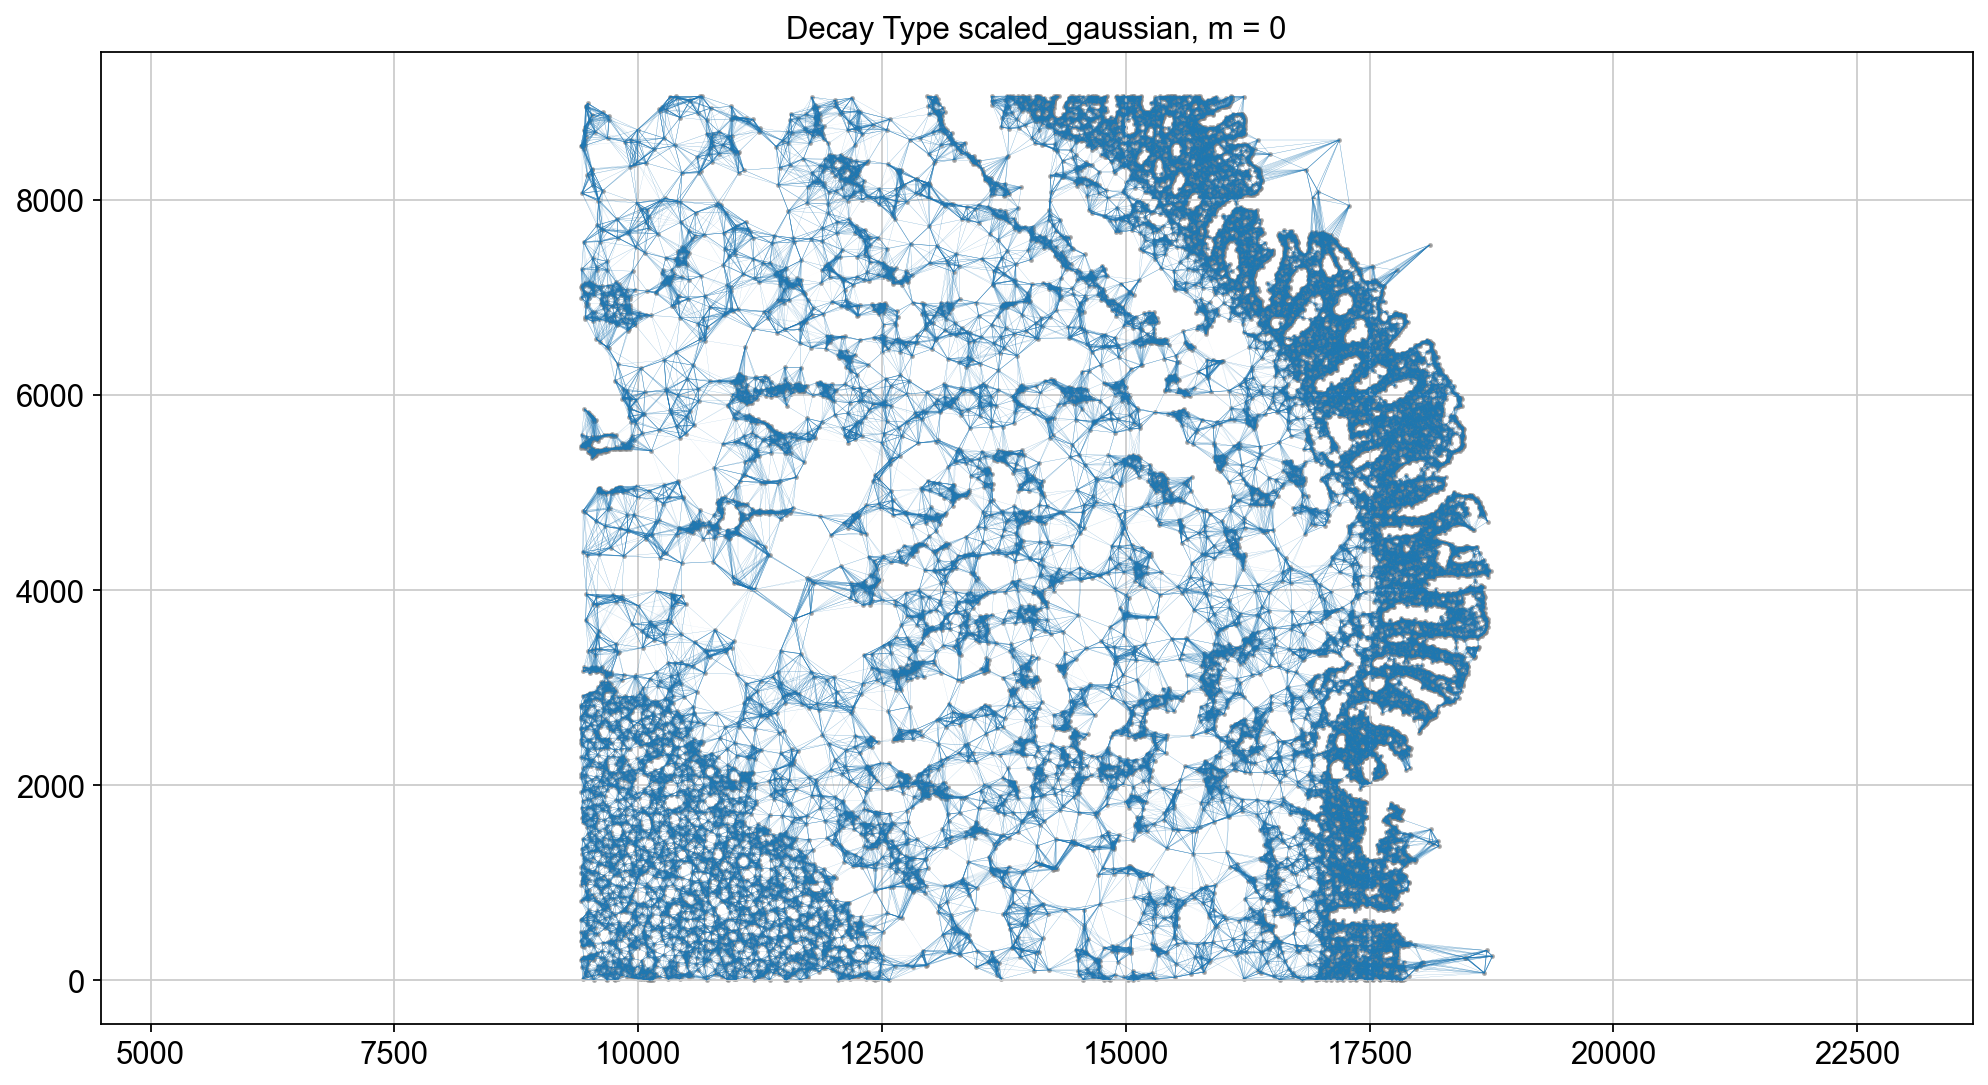

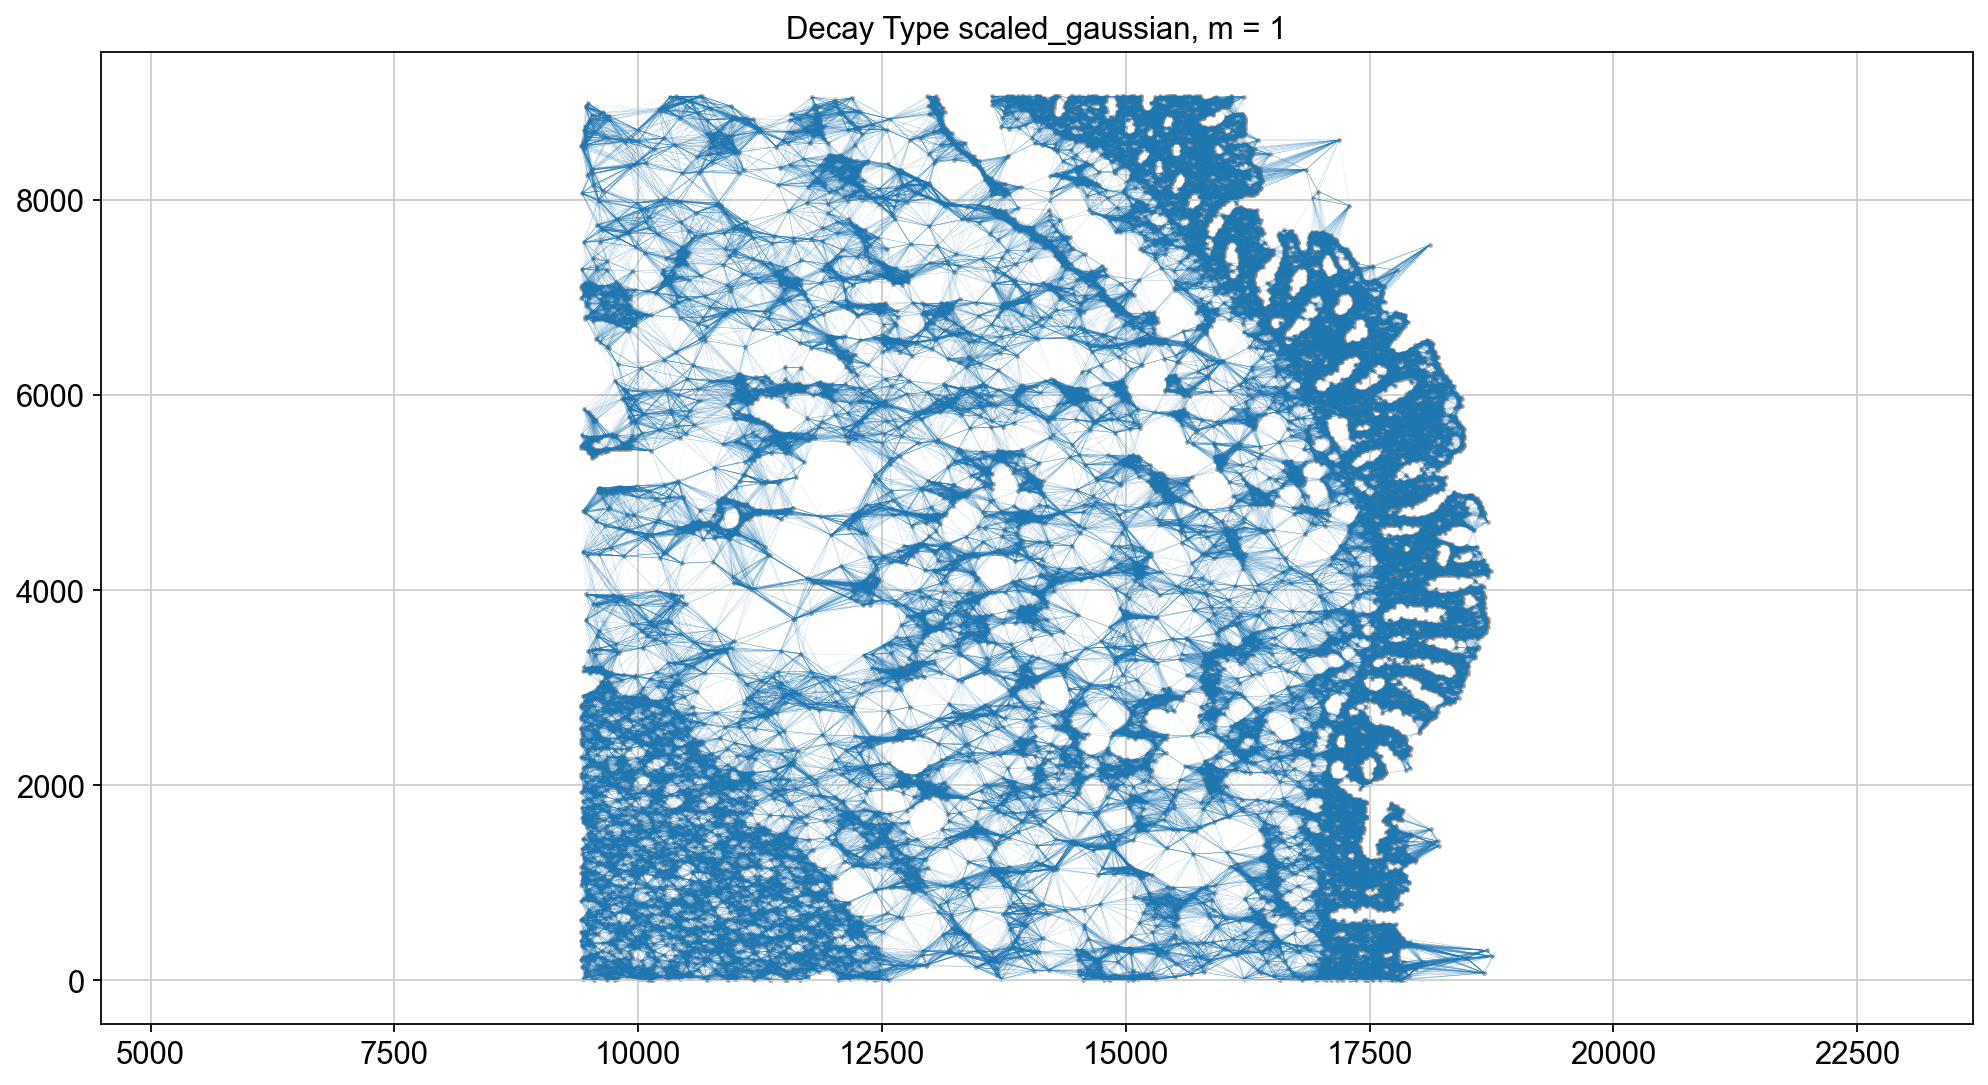

In [9]:
nbrs = median_dist_to_nearest_neighbour(adata, key=coord_keys[2])
banksy_dict = initialize_banksy(adata,
                                coord_keys,
                                k_geom,
                                nbr_weight_decay=nbr_weight_decay,
                                max_m=max_m,
                                plt_edge_hist=False,
                                plt_nbr_weights=True,
                                plt_agf_angles=False,
                                plt_theta=False
                                )


## Create BANKSY Matrix

In [10]:
banksy_dict, banksy_matrix = generate_banksy_matrix(adata,
                                                    banksy_dict,
                                                    lambda_list,
                                                    max_m)

# Create output folder path if not done so
output_folder = os.path.join(file_path, 'BANKSY-Results')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

Runtime Oct-24-2024-16-37

47 genes to be analysed:
Gene List:
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46'],
      dtype='object')

Decay Type: scaled_gaussian
Weights Object: {'weights': {0: <25403x25403 sparse matrix of type '<class 'numpy.float64'>'
	with 381045 stored elements in Compressed Sparse Row format>, 1: <25403x25403 sparse matrix of type '<class 'numpy.complex128'>'
	with 762090 stored elements in Compressed Sparse Row format>}}

Nbr matrix | Mean: -0.06 | Std: 0.36
Size of Nbr | Shape: (25403, 47)
Top 3 entries of Nbr Mat:

[[ 0.11408795 -0.04208128  0.0973344 ]
 [-0.10411027 -0.00508791 -0.00166787]
 [ 0.32726094  0.2019266   0.35902501]]

AGF matrix | Mean: 0.11 | Std: 0.16
Size of AGF mat (m = 1) | Shape: (25403, 47)


### Perform Dimensionality Reduction
1. Perform PCA to produce PCA embeddings for Leiden Clustering
2. UMAP (just for visualization)

Current decay types: ['scaled_gaussian']

Reducing dims of dataset in (Index = scaled_gaussian, lambda = 0.8)

Setting the total number of PC = 20
Original shape of matrix: (25403, 141)
Reduced shape of matrix: (25403, 20)
------------------------------------------------------------
min_value = -23.166391736083003, mean = 1.6032174647454846e-16, max = 75.80332002123625

Conducting UMAP and adding embeddings to adata.obsm["reduced_pc_20_umap"]
UMAP embedding
------------------------------------------------------------
shape: (25403, 2)


AxisArrays with keys: reduced_pc_20, reduced_pc_20_umap


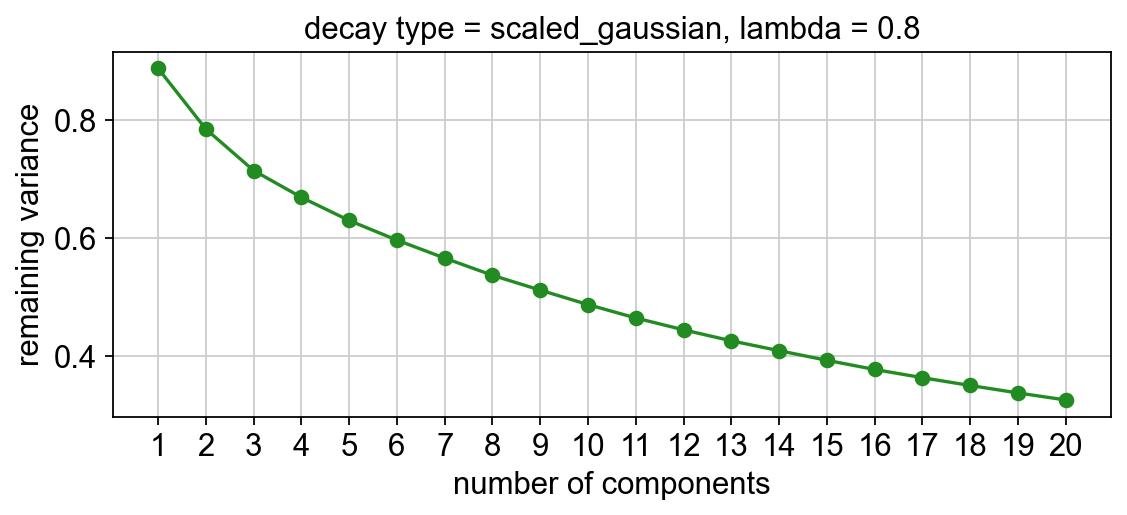

In [11]:
from banksy_utils.umap_pca import pca_umap

pca_umap(banksy_dict,
         pca_dims = pca_dims,
         add_umap = True
         )

## Run Leiden Parition and plot the results

In [12]:
from banksy.cluster_methods import run_Leiden_partition

results_df, max_num_labels = run_Leiden_partition(
    banksy_dict,
    resolutions,
    num_nn = 50,
    num_iterations = -1,
    partition_seed = 1234,
    match_labels = True,
    max_labels = max_labels,
)




Decay type: scaled_gaussian
Neighbourhood Contribution (Lambda Parameter): 0.8
reduced_pc_20 

reduced_pc_20_umap 

PCA dims to analyse: [20]

Setting up partitioner for (nbr decay = scaled_gaussian), Neighbourhood contribution = 0.8, PCA dimensions = 20)


Nearest-neighbour weighted graph (dtype: float64, shape: (25403, 25403)) has 1270150 nonzero entries.
---- Ran find_nn in 22.02 s ----


Nearest-neighbour connectivity graph (dtype: int16, shape: (25403, 25403)) has 1270150 nonzero entries.

(after computing shared NN)
Allowing nearest neighbours only reduced the number of shared NN from 16457643 to 1268472.


Shared nearest-neighbour (connections only) graph (dtype: int16, shape: (25403, 25403)) has 1222619 nonzero entries.

Shared nearest-neighbour (number of shared neighbours as weights) graph (dtype: int16, shape: (25403, 25403)) has 1222619 nonzero entries.

sNN graph data:
[16 12 16 ... 33 35 19]

---- Ran shared_nn in 1.20 s ----


-- Multiplying sNN connectivity by weights -

decay  lambda_param  num_pcs  \
scaled_gaussian_pc20_nc0.80_r0.08  scaled_gaussian           0.8       20   
scaled_gaussian_pc20_nc0.80_r0.09  scaled_gaussian           0.8       20   
scaled_gaussian_pc20_nc0.80_r0.10  scaled_gaussian           0.8       20   

                                   resolution  num_labels  \
scaled_gaussian_pc20_nc0.80_r0.08        0.08           2   
scaled_gaussian_pc20_nc0.80_r0.09        0.09           2   
scaled_gaussian_pc20_nc0.80_r0.10        0.10           3   

                                                                              labels  \
scaled_gaussian_pc20_nc0.80_r0.08  Label object:\nNumber of labels: 2, number of ...   
scaled_gaussian_pc20_nc0.80_r0.09  Label object:\nNumber of labels: 2, number of ...   
scaled_gaussian_pc20_nc0.80_r0.10  Label object:\nNumber of labels: 3, number of ...   

                                                                               adata  \
scaled_gaussian_pc20_nc0.80_r0.08  [[[View of AnnData object with n_obs × n_vars ...   
scaled_gaussian_pc20_nc0.80_r0.09  [[[View of AnnData object with n_obs × n_vars ...   
scaled_gaussian_pc20_nc0.80_r0.10  [[[View of AnnData object with n_obs × n_vars ...   

                                                                           relabeled  
scaled_gaussian_pc20_nc0.80_r0.08  Label object:\nNumber of labels: 2, number of ...  
scaled_gaussian_pc20_nc0.80_r0.09  Label object:\nNumber of labels: 2, number of ...  
scaled_gaussian_pc20_nc0.80_r0.10  Label object:\nNumber of labels: 3, number of ...

In [13]:
results_df

decay  lambda_param  num_pcs  \
scaled_gaussian_pc20_nc0.80_r0.08  scaled_gaussian           0.8       20   
scaled_gaussian_pc20_nc0.80_r0.09  scaled_gaussian           0.8       20   
scaled_gaussian_pc20_nc0.80_r0.10  scaled_gaussian           0.8       20   

                                   resolution  num_labels  \
scaled_gaussian_pc20_nc0.80_r0.08        0.08           2   
scaled_gaussian_pc20_nc0.80_r0.09        0.09           2   
scaled_gaussian_pc20_nc0.80_r0.10        0.10           3   

                                                                              labels  \
scaled_gaussian_pc20_nc0.80_r0.08  Label object:\nNumber of labels: 2, number of ...   
scaled_gaussian_pc20_nc0.80_r0.09  Label object:\nNumber of labels: 2, number of ...   
scaled_gaussian_pc20_nc0.80_r0.10  Label object:\nNumber of labels: 3, number of ...   

                                                                               adata  \
scaled_gaussian_pc20_nc0.80_r0.08  [[[View of AnnData object with n_obs × n_vars ...   
scaled_gaussian_pc20_nc0.80_r0.09  [[[View of AnnData object with n_obs × n_vars ...   
scaled_gaussian_pc20_nc0.80_r0.10  [[[View of AnnData object with n_obs × n_vars ...   

                                                                           relabeled  
scaled_gaussian_pc20_nc0.80_r0.08  Label object:\nNumber of labels: 2, number of ...  
scaled_gaussian_pc20_nc0.80_r0.09  Label object:\nNumber of labels: 2, number of ...  
scaled_gaussian_pc20_nc0.80_r0.10  Label object:\nNumber of labels: 3, number of ...

In [14]:
results_df[results_df['num_labels']==3]

decay  lambda_param  num_pcs  \
scaled_gaussian_pc20_nc0.80_r0.10  scaled_gaussian           0.8       20   

                                   resolution  num_labels  \
scaled_gaussian_pc20_nc0.80_r0.10         0.1           3   

                                                                              labels  \
scaled_gaussian_pc20_nc0.80_r0.10  Label object:\nNumber of labels: 3, number of ...   

                                                                               adata  \
scaled_gaussian_pc20_nc0.80_r0.10  [[[View of AnnData object with n_obs × n_vars ...   

                                                                           relabeled  
scaled_gaussian_pc20_nc0.80_r0.10  Label object:\nNumber of labels: 3, number of ...

number of labels: 3
---- Ran plot_2d_embeddings in 0.00 s ----

number of labels: 3
---- Ran plot_2d_embeddings in 0.00 s ----

number of labels: 3
---- Ran plot_2d_embeddings in 0.00 s ----

---- Ran row_normalize in 0.00 s ----


matrix multiplying labels x weights x labels-transpose ((3, 25403) x (25403, 25403) x (25403, 3))

Saving full-figure at data\CODEX\CODEX_csv_data\BANKSY-Results\CODEX-['B012_Ileum', 'B012_Right', 'B012_Trans']_scaled_gaussian_pc20_nc0.80_r0.10_full_figure.png


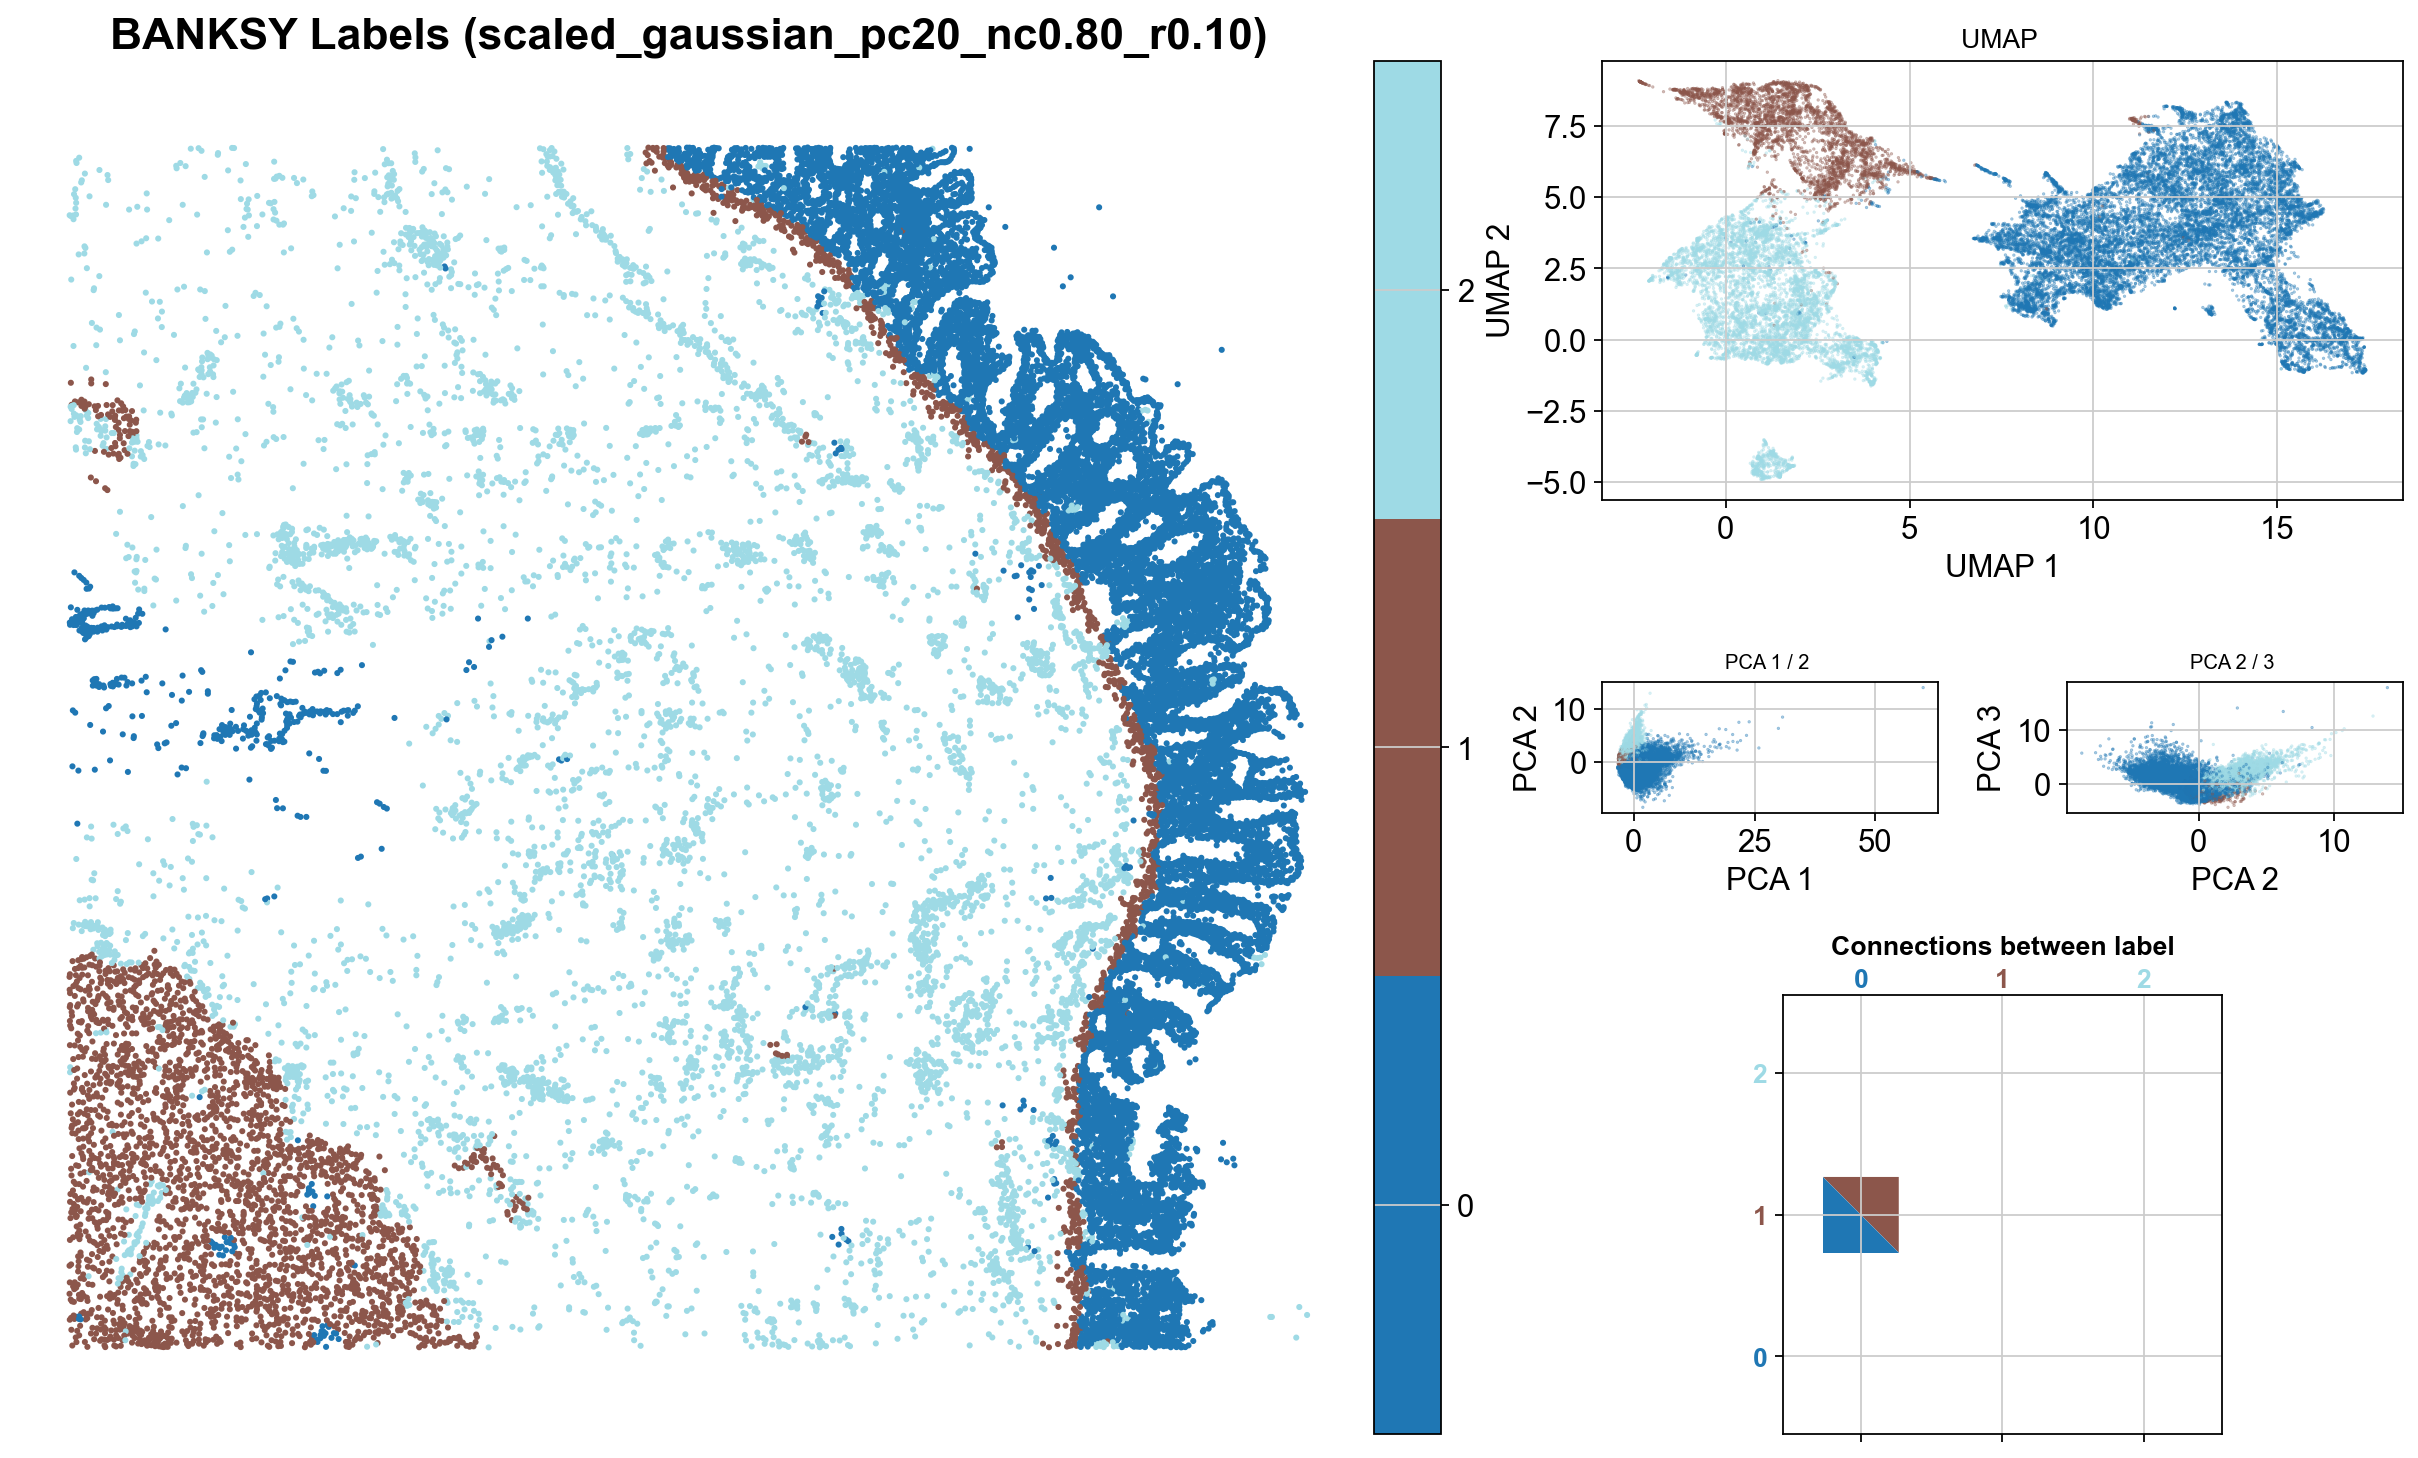

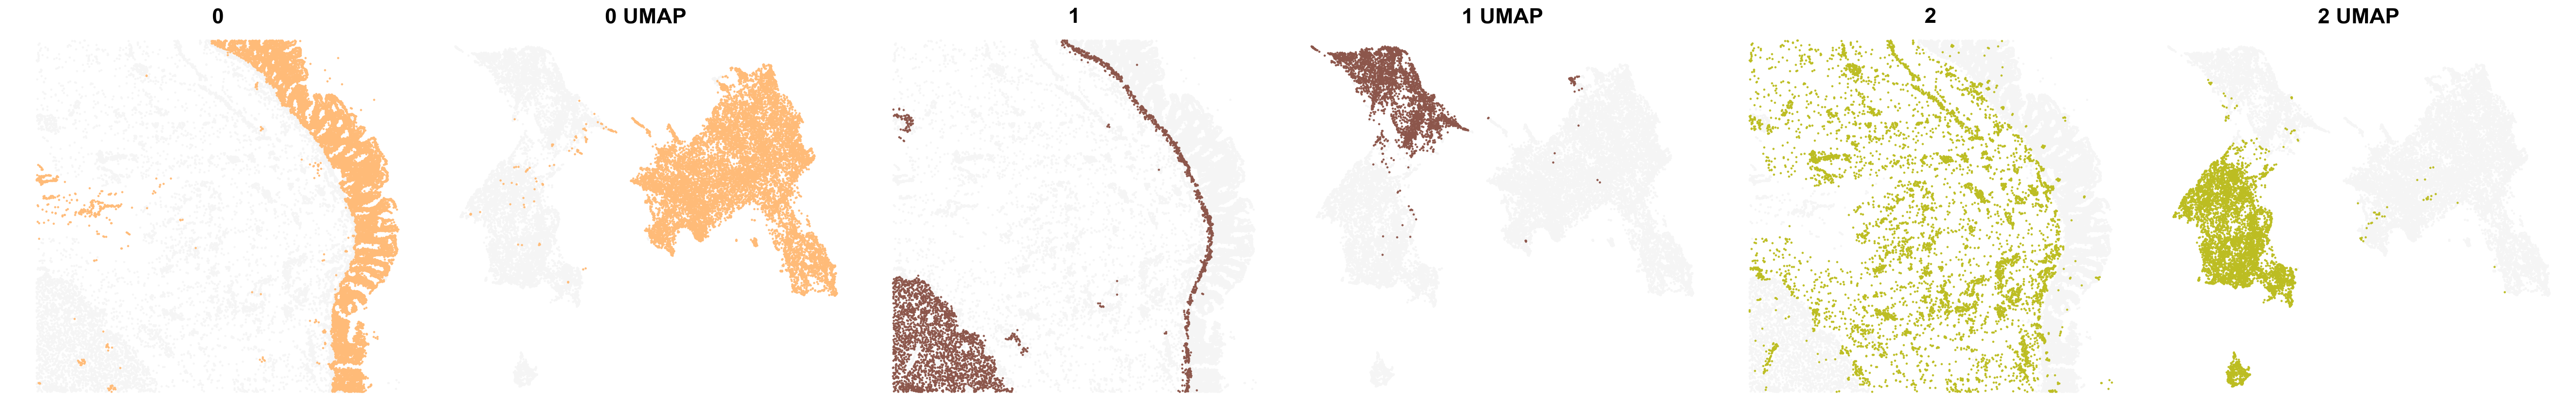

In [15]:
from banksy.plot_banksy import plot_results

c_map =  'tab20' # specify color map
weights_graph =  banksy_dict['scaled_gaussian']['weights'][1]

plot_results(
    #results_df,
    results_df[results_df['num_labels']==3],
    weights_graph,
    c_map,
    match_labels = True,
    coord_keys = coord_keys,
    max_num_labels  =  max_num_labels, 
    save_path = os.path.join(file_path, 'BANKSY-Results'),
    save_fig = False, # Save Spatial Plot Only
    save_fullfig = True, # Save Full Plot
    dataset_name = f"CODEX-{unique_regions}",
    save_labels=True
)
results_df.to_csv(os.path.join(file_path, "Summary.csv"))

In [16]:
# We can access the clusters from banksy using the following command
banksy_spatial_clusters = results_df.labels[results_df.index[0]]
banksy_spatial_clusters.dense

array([0, 0, 0, ..., 0, 1, 0])

### BANKSY's labels show good agreement with annotated Neighbourhoods

In [17]:
from sklearn.metrics import adjusted_rand_score as ari, adjusted_mutual_info_score as ami
from sklearn.metrics import matthews_corrcoef as mcc
def calculate_metrics(cluster_labels, annotated_labels, verbose=True):
    # A custom function to calcualte all metrics
    ari_score  = ari(cluster_labels, annotated_labels)
    ami_score =   ami(cluster_labels, annotated_labels)

    if isinstance(annotated_labels.dtype, pd.CategoricalDtype):
        print("Converting annotations to required 'int' type for computing MCC")
        annotated_labels = annotated_labels.cat.codes

    mcc_score =  mcc(cluster_labels,annotated_labels)
    if verbose:
        print("--- Summarizing metrics ---")
        print(f"ARI: {ari_score:.3f}")
        print(f"AMI: {ami_score:.3f}")
        print(f"MCC: {mcc_score:.3f}")
    return ari_score, ami_score, mcc_score

banksy_ari, banksy_ami, banksy_mcc = calculate_metrics(banksy_spatial_clusters.dense, adata.obs['Tissue Segment'])
#nonspatial_ari, nonspatial_ami, nonspatial_mcc = calculate_metrics(nonspatial_clusters.dense, adata.obs['Community'])

Converting annotations to required 'int' type for computing MCC
--- Summarizing metrics ---
ARI: 0.703
AMI: 0.618
MCC: 0.607
